In [290]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import matplotlib.colors as colors

In [286]:
def sin_func(t, A_0, A, f, phi):
    return A_0 + A * np.sin(2 * np.pi * f * t + phi)

def square_sin_error_weighted(time, data, data_sig, freqs, phis, man_phi, want_2d):
    freq_errors=[]
    best_phis = []
    for f in freqs:
        phi_errors=[]
        for phi in phis: 
            phi_errors.append(0.5*np.sum(1/(data_sig**2) * (data - np.sin(2*np.pi*f*time + phi - man_phi))**2))
        if want_2d:
            freq_errors.append(phi_errors)
        else:
            freq_errors.append(np.min(phi_errors))
            best_phis.append(phis[np.argmin(phi_errors)])
            
    return np.array(freq_errors), np.array(best_phis)

def gen_ellipse(pcov_subspace, popt_subvector, s=5.991):
    
    # Get ellipse center
    x_0 = popt_subvector[0]  # frequency
    y_0 = popt_subvector[1]  # phase
    
    #get eigvals, eigvecs of cov matrix. Eigvals are the variances in pre-rotated frame
    evals, evecs = np.linalg.eigh(pcov_subspace)

    # Generate ellipse parametrically
    t = np.linspace(0, 2*np.pi, 100)
    a = np.sqrt(s * evals[0]) 
    b = np.sqrt(s * evals[1])
    x_std = a * np.cos(t)
    y_std = b * np.sin(t)

    # stack to prep for rotation by matrix mult
    points_std = np.vstack([x_std, y_std])
    
    # Eigvec matrix happens to be rotation matrix we need
    rotated_points = evecs @ points_std
    
    # Translate to be centered on the fit convergence value
    rotated_points[0] = rotated_points[0] + x_0
    rotated_points[1] = rotated_points[1] + y_0

    return rotated_points


def fit_and_plot(time, data, data_unc, init_guess, color, no, ax=None):
    popt, pcov = curve_fit(sin_func, time, data, p0=init_guess, sigma=data_unc)
    print(f'Fit {no} Results:')
    print(f'  Offset: {popt[0]:.3f} ± {np.sqrt(pcov[0, 0]):.3f}')
    print(f'  Amplitude: {popt[1]:.3f} ± {np.sqrt(pcov[1, 1]):.3f}')
    print(f'  Freq: {popt[2]*1e-3:.3f} ± {np.sqrt(pcov[2, 2])*1e-3:.3f} (kHz)')
    print(f'  Phase: {popt[3]/np.pi:.3f} ± {np.sqrt(pcov[3,3])/np.pi:.3f} (π rad)')
    
    sub_vec = popt[2:]
    sub_mat = pcov[2:, 2:]
    rot_ellipse = gen_ellipse(sub_mat, sub_vec)
    
    # Use provided ax or current axes
    if ax is None:
        ax = plt.gca()  # Get current axes
    
    ax.plot(rot_ellipse[0]*1e-3, rot_ellipse[1]/np.pi, label=f'Fit {no} Ellipse', color=color)
    ax.plot(popt[2]*1e-3, popt[3]/np.pi, '*', label=f'Fit {no} Convergence', color=color, markersize=10)
    ax.plot(np.array([init_guess[2],popt[2]])*1e-3, np.array([init_guess[3],popt[3]])/np.pi, label=f'Fit {no} Path', color=color, linestyle='--')
    return popt, pcov

def find_global_min(errors_gate_2d, freq_range, phi_range):
    global_min_idx = np.unravel_index(np.argmin(errors_gate_2d), errors_gate_2d.shape)
    return freq_range[global_min_idx[0]], phi_range[global_min_idx[1]]  



class Fringe:
    def __init__(self, A_0, A, f_0, phi):
        self.f_0 = f_0
        self.A_0 = A_0
        self.A = A
        self.phi = phi

    def eval_pure(self, t):
        return self.A_0 + self.A * np.sin(2 * np.pi * self.f_0 * t + self.phi)

    def add_noise(self, data, noise_level):
        noise = np.random.normal(0, noise_level, size=data.shape)
        return data + noise
    
    def eval_noisy(self, t):
        data_pure = self.eval_pure(t)
        data1 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data2 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data3 = self.add_noise(np.array(data_pure), noise_level=0.3)
        data_avg = np.mean([data1, data2, data3], axis=0)
        data_std = np.std([data1, data2, data3], axis=0)

        return data_avg, data_std

def gen_sample(fringe, t_hold_center, f_samp, no_samp):
    if no_samp % 2 == 0:
        raise ValueError("no_samp must be odd")
    dt = 1 / f_samp
    half_span = (no_samp - 1) // 2 * dt
    t_range = np.linspace(t_hold_center - half_span, 
                          t_hold_center + half_span, 
                          no_samp)
    avg, std = fringe.eval_noisy(t_range)
    # print(t_range)
    return t_range, avg, std


Text(0.5, 1.0, 'Ex. Object Oriented Fringe \n[T hold center value: 0.8 ms, 11 desired points]')

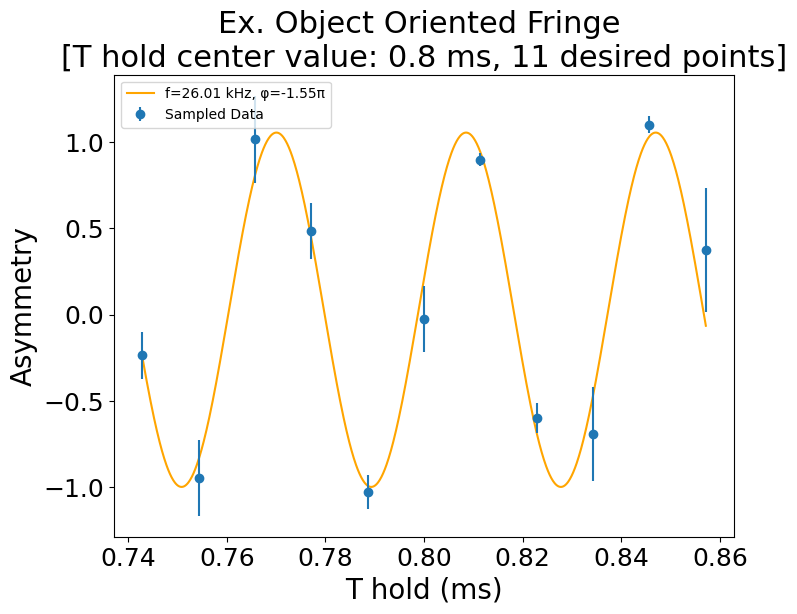

In [287]:
f_1 = 25e3
tau_1 = 1 / f_1
f_samp1 = f_1 * 3.5
width1 = 2 * tau_1
want_no_samp = 11
center_t1_hold = tau_1*20
PHI_RANGE = np.linspace(-np.pi, np.pi, 100)
FREQ_RANGE = np.linspace(0, f_samp1/2, 1000)

little_g_fringe = Fringe(A_0=0, A=1, f_0=f_1, phi=0)

t01s, avg01s, std01s = gen_sample(little_g_fringe, center_t1_hold, f_samp1, want_no_samp)
popt1, pcov1 = curve_fit(sin_func, t01s, avg01s, p0=[0, 1, f_1, 0], sigma=std01s)
plot_t1s = np.linspace(t01s[0], t01s[-1], 1000)
fringe_fit = sin_func(plot_t1s, *popt1)


plt.plot(plot_t1s*1e3, fringe_fit, label=f'f={popt1[2]*1e-3:.2f} kHz, φ={popt1[3]/np.pi:.2f}π', color='orange')
plt.errorbar(t01s*1e3, avg01s, yerr=std01s, fmt='o', label='Sampled Data')
plt.xlabel('T hold (ms)')
plt.ylabel('Asymmetry')
plt.legend()
plt.title(f'Ex. Object Oriented Fringe \n[T hold center value: {center_t1_hold*1e3:.1f} ms, {want_no_samp} desired points]')

Fit 1 Results:
  Offset: 0.028 ± 0.043
  Amplitude: 1.027 ± 0.044
  Freq: 26.006 ± 0.313 (kHz)
  Phase: -5.552 ± 0.503 (π rad)
Fit 2 Results:
  Offset: 0.028 ± 0.043
  Amplitude: 1.027 ± 0.044
  Freq: 26.006 ± 0.313 (kHz)
  Phase: 2.448 ± 0.503 (π rad)
Fit 3 Results:
  Offset: 0.028 ± 0.043
  Amplitude: 1.027 ± 0.044
  Freq: 26.006 ± 0.313 (kHz)
  Phase: -1.552 ± 0.503 (π rad)


Text(0.5, 0.98, 'Single Slit Fitting\nTrue Freq: 25.000  Freq Fit: 26.006 +/- 0.313 kHz')

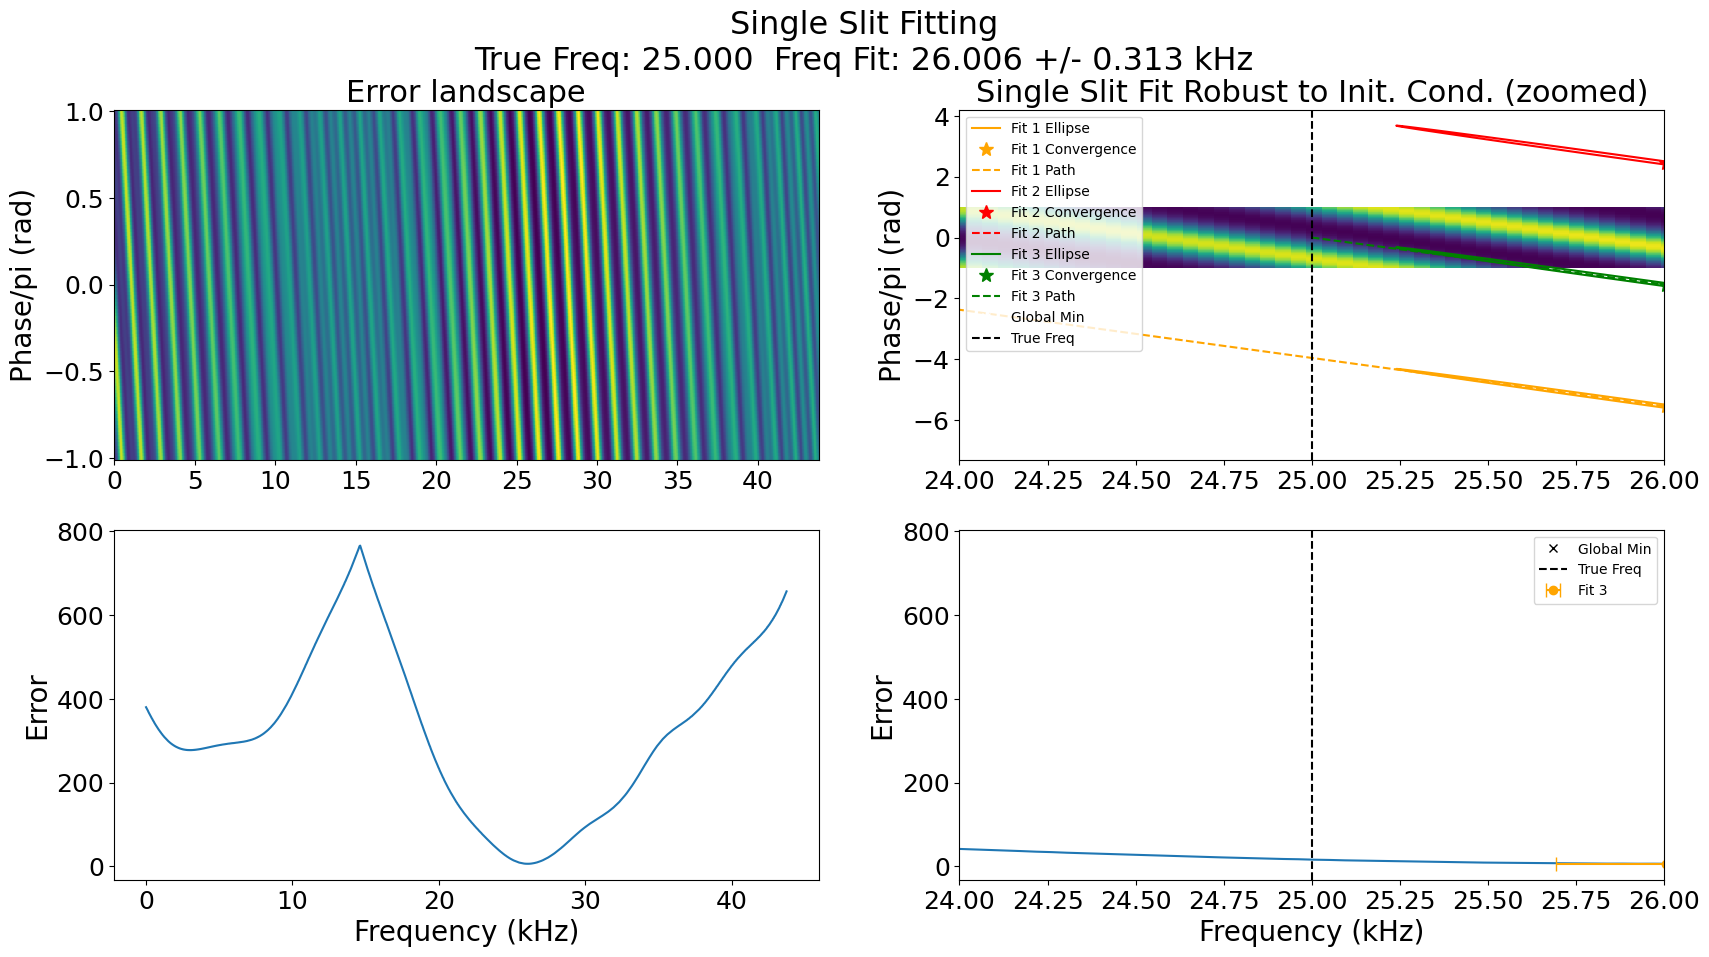

In [288]:

errors_gate_2d, _ = square_sin_error_weighted(t01s, avg01s, std01s, FREQ_RANGE, PHI_RANGE, man_phi=0.796, want_2d=True)
gate_mesh = np.meshgrid(PHI_RANGE, FREQ_RANGE)
errors_gate_1d , phis_gate_1d = square_sin_error_weighted(t01s, avg01s, std01s, FREQ_RANGE, PHI_RANGE, man_phi=0.796, want_2d=False)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
globmin_f1, globmin_phi1 = find_global_min(errors_gate_2d, FREQ_RANGE, PHI_RANGE)

ax[0][0].pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto')
ax[0][0].set_title('Error landscape')
ax[0][0].set_ylabel('Phase/pi (rad)')

ax[1][0].plot(FREQ_RANGE*1e-3, errors_gate_1d)
ax[1][0].set_xlabel('Frequency (kHz)')
ax[1][0].set_ylabel('Error')
# ax[1].set_xlim(24,26)

ax[0][1].pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(np.pi), errors_gate_2d, shading='auto')
popt1a, pcov1a = fit_and_plot(t01s, avg01s, std01s, [0, 1, f_1*0.9, 0], 'orange', 1, ax=ax[0][1])
popt1b, pcov1b = fit_and_plot(t01s, avg01s, std01s, [0,1,f_1*1.1,0], 'red', 2, ax=ax[0][1])
popt1c, pcov1c = fit_and_plot(t01s, avg01s, std01s, [0,1,f_1,0], 'green', 3, ax=ax[0][1])
globmin_f, globmin_phi = find_global_min(errors_gate_2d, FREQ_RANGE, PHI_RANGE)
ax[0][1].plot(globmin_f*1e-3, globmin_phi/np.pi, 'x', color='white', label='Global Min')
ax[0][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[0][1].set_title('Single Slit Fit Robust to Init. Cond. (zoomed)')
ax[0][1].set_ylabel('Phase/pi (rad)')
ax[0][1].set_xlim(24,26)
ax[0][1].legend()

ax[1][1].plot(FREQ_RANGE*1e-3, errors_gate_1d)
ax[1][1].plot(globmin_f*1e-3, np.min(errors_gate_1d), 'x', color='black', label='Global Min')
ax[1][1].errorbar(popt1c[2]*1e-3, errors_gate_1d[np.argmin(np.abs(FREQ_RANGE - popt1c[2]))], xerr=np.sqrt(pcov1c[2,2])*1e-3, fmt='o', color='orange', label='Fit 3', capsize=5)
ax[1][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[1][1].set_xlabel('Frequency (kHz)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlim(24,26)
ax[1][1].legend()

fig.suptitle(f'Single Slit Fitting\nTrue Freq: {f_1*1e-3:.3f}  Freq Fit: {popt1c[2]*1e-3:.3f} +/- {np.sqrt(pcov1c[2,2])*1e-3:.3f} kHz', fontsize=23)

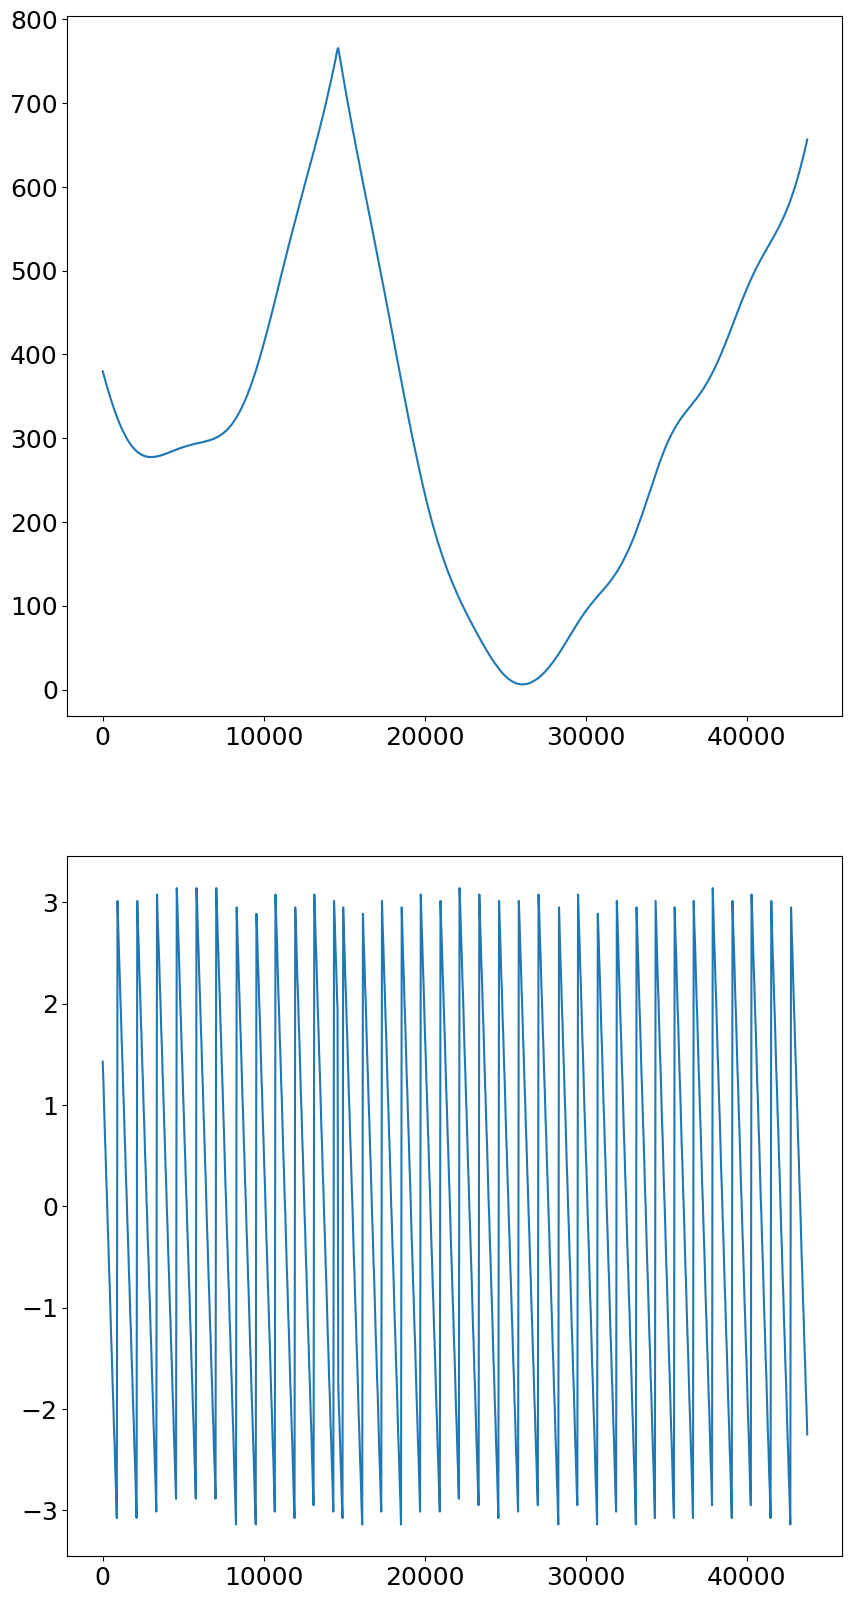

In [289]:

fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].plot(FREQ_RANGE, errors_gate_1d)
ax[1].plot(FREQ_RANGE, phis_gate_1d)

In [254]:
print('fitted phases (mod 2 pi)/pi:')
print((popt1a[3]%(2*np.pi))/np.pi, (popt1b[3]%(2*np.pi))/np.pi, (popt1c[3]%(2*np.pi))/np.pi)

print('')
print('Fitted Freqs:')
print((popt1a[2]*1e-3), (popt1b[2]*1e-3), (popt1c[2]*1e-3))

new_f_guess = popt1c[2]
new_phi_guess = popt1c[3]%(2*np.pi)

fitted phases (mod 2 pi)/pi:
1.646936470282127 1.6469413886000632 1.6469399569826007

Fitted Freqs:
25.23974840480261 25.239745383737336 25.239746180454524


Text(0.5, 1.0, 'Both Fringes')

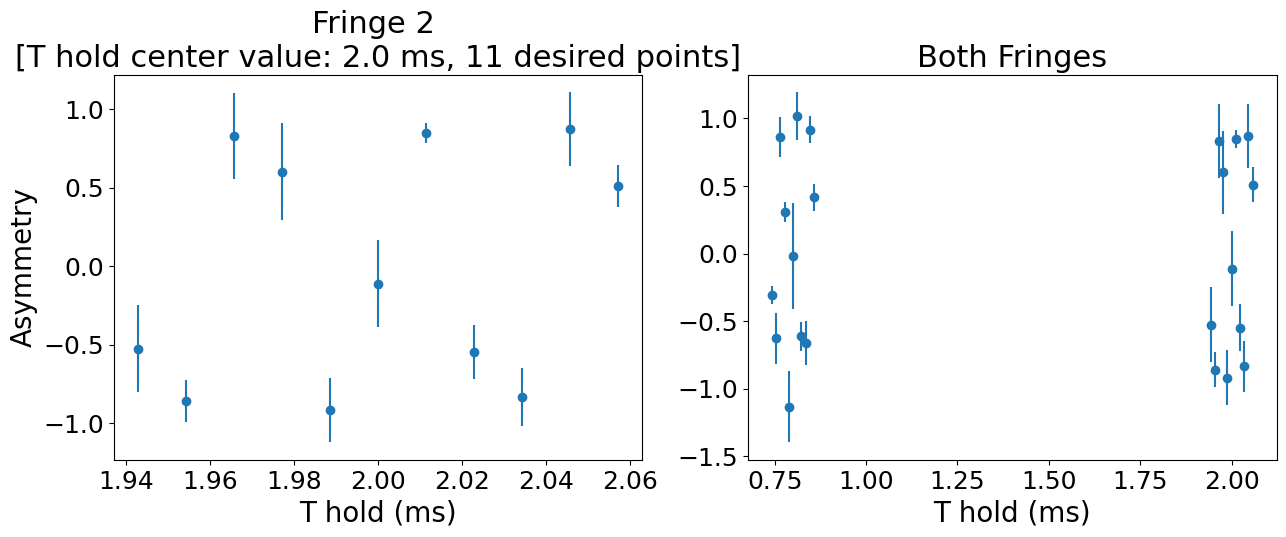

In [255]:
t2_center = center_t1_hold + 30 * tau_1
t02s, avg02s, std02s = gen_sample(little_g_fringe, t2_center, f_samp1, want_no_samp)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].errorbar(t02s*1e3, avg02s, yerr=std02s, fmt='o', label='Sampled Data')
ax[0].set_xlabel('T hold (ms)')
ax[0].set_ylabel('Asymmetry')
ax[0].set_title(f'Fringe 2 \n[T hold center value: {t2_center*1e3:.1f} ms, {want_no_samp} desired points]')

t12s, avg12s, std12s = np.concatenate((t01s, t02s)), np.concatenate((avg01s, avg02s)), np.concatenate((std01s, std02s))
ax[1].errorbar(t12s*1e3, avg12s, yerr=std12s, fmt='o', label='Sampled Data')
ax[1].set_xlabel('T hold (ms)')
ax[1].set_title('Both Fringes')


Fit Old Results:
  Offset: 0.047 ± 0.046
  Amplitude: 0.979 ± 0.064
  Freq: 25.240 ± 0.167 (kHz)
  Phase: -0.353 ± 0.267 (π rad)
Fit 1 Results:
  Offset: 0.011 ± 0.031
  Amplitude: 0.952 ± 0.041
  Freq: 24.993 ± 0.012 (kHz)
  Phase: 2.030 ± 0.030 (π rad)


Text(0.5, 0.98, 'Double Slit Fitting\nTrue Freq: 25.0000  Freq Fit: 24.9926 +/- 0.012 kHz')

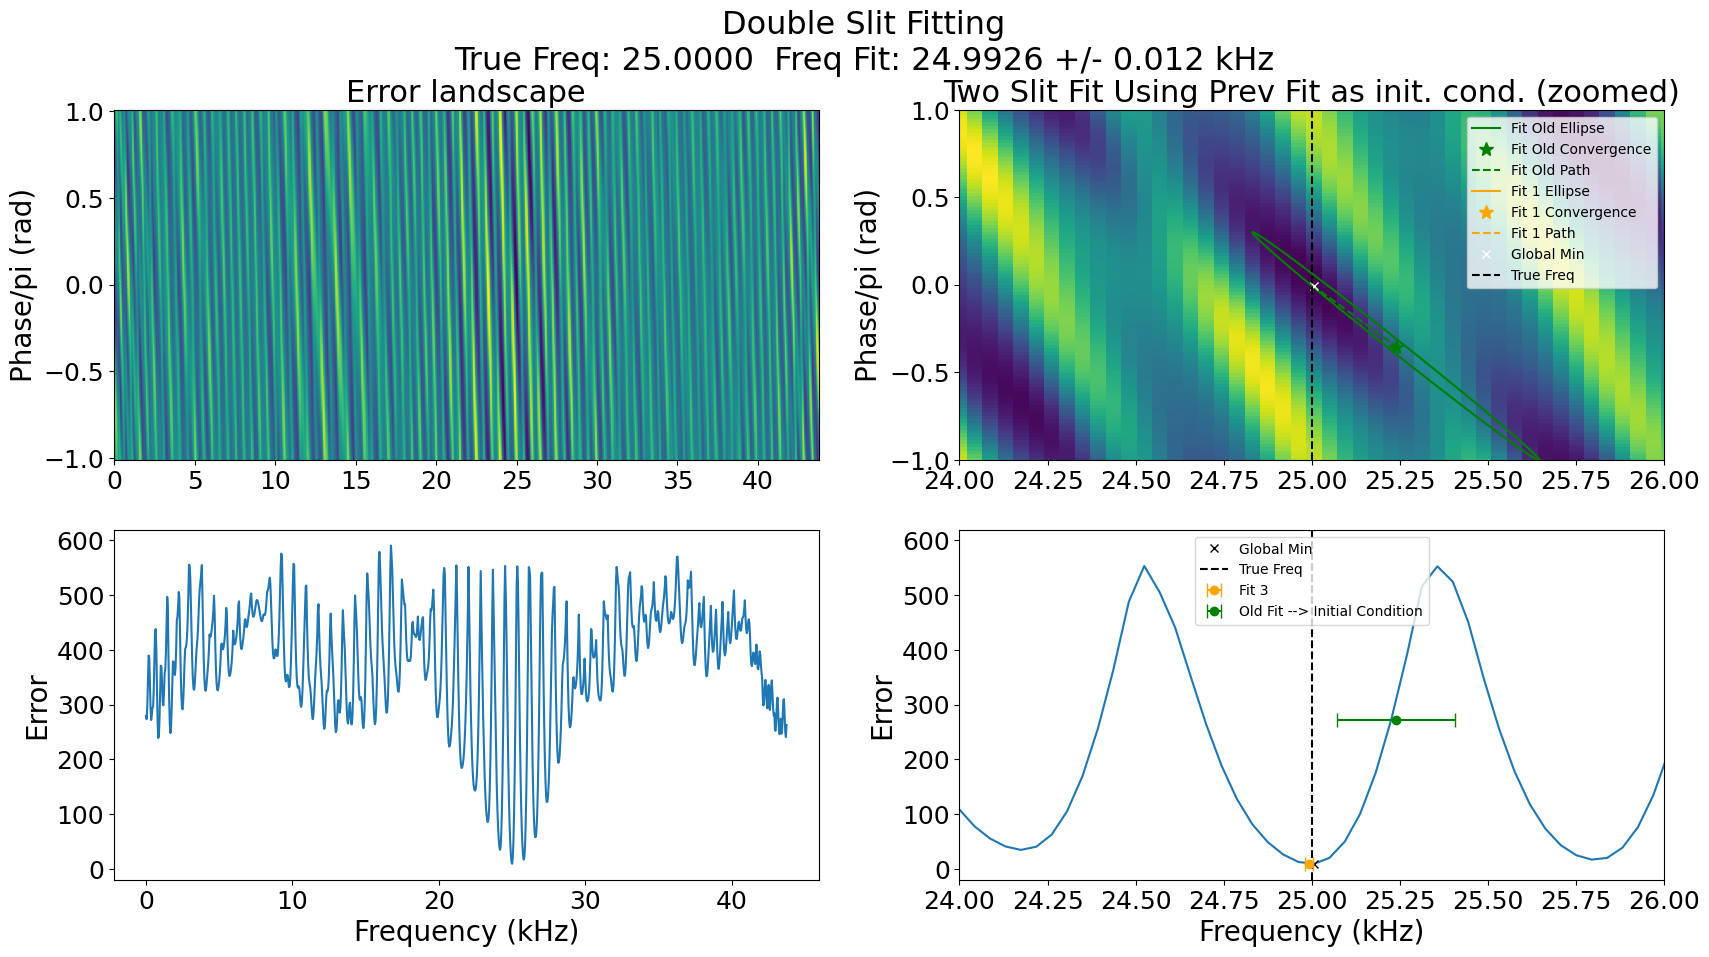

In [256]:
errors_gate12_2d = square_sin_error_weighted(t12s, avg12s, std12s, FREQ_RANGE, PHI_RANGE, want_2d=True)
gate_mesh12 = np.meshgrid(PHI_RANGE, FREQ_RANGE)
errors_gate12_1d = square_sin_error_weighted(t12s, avg12s, std12s, FREQ_RANGE, PHI_RANGE, want_2d=False)
globmin_f12, globmin_phi12 = find_global_min(errors_gate12_2d, FREQ_RANGE, PHI_RANGE)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
globmin_f1, globmin_phi1 = find_global_min(errors_gate_2d, FREQ_RANGE, PHI_RANGE)

ax[0][0].pcolormesh(gate_mesh12[1]*1e-3, gate_mesh12[0]/(np.pi), errors_gate12_2d, shading='auto')
ax[0][0].set_title('Error landscape')
ax[0][0].set_ylabel('Phase/pi (rad)')

ax[1][0].plot(FREQ_RANGE*1e-3, errors_gate12_1d)
ax[1][0].set_xlabel('Frequency (kHz)')
ax[1][0].set_ylabel('Error')
# ax[1].set_xlim(24,26)

ax[0][1].pcolormesh(gate_mesh12[1]*1e-3, gate_mesh12[0]/(np.pi), errors_gate12_2d, shading='auto')

# Old Fit Ellipse
popt1c, pcov1c = fit_and_plot(t01s, avg01s, std01s, [0,1,f_1,0], 'green', 'Old', ax=ax[0][1])

# New fit
popt12a, pcov12a = fit_and_plot(t12s, avg12s, std12s, [0, 1, new_f_guess, new_phi_guess], 'orange', 1, ax=ax[0][1])

ax[0][1].plot(globmin_f12*1e-3, globmin_phi12/np.pi, 'x', color='white', label='Global Min')
ax[0][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[0][1].set_title('Two Slit Fit Using Prev Fit as init. cond. (zoomed)')
ax[0][1].set_ylabel('Phase/pi (rad)')
ax[0][1].set_xlim(24,26)
ax[0][1].set_ylim(-1,1)
ax[0][1].legend()

ax[1][1].plot(FREQ_RANGE*1e-3, errors_gate12_1d)
ax[1][1].plot(globmin_f12*1e-3, np.min(errors_gate12_1d), 'x', color='black', label='Global Min')
ax[1][1].errorbar(popt12a[2]*1e-3, errors_gate12_1d[np.argmin(np.abs(FREQ_RANGE - popt12a[2]))], xerr=np.sqrt(pcov12a[2,2])*1e-3, fmt='o', color='orange', label='Fit 3', capsize=5)
ax[1][1].errorbar(popt1c[2]*1e-3, errors_gate12_1d[np.argmin(np.abs(FREQ_RANGE - popt1c[2]))], xerr=np.sqrt(pcov1c[2,2])*1e-3, fmt='o', color='green', label='Old Fit --> Initial Condition', capsize=5)

ax[1][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[1][1].set_xlabel('Frequency (kHz)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlim(24,26)
ax[1][1].legend()

fig.suptitle(f'Double Slit Fitting\nTrue Freq: {f_1*1e-3:.4f}  Freq Fit: {popt12a[2]*1e-3:.4f} +/- {np.sqrt(pcov12a[2,2])*1e-3:.3f} kHz', fontsize=23)


### Compare to equal (+1) no. points but with continuous gate ###

Text(0, 0.5, 'Asymmetry')

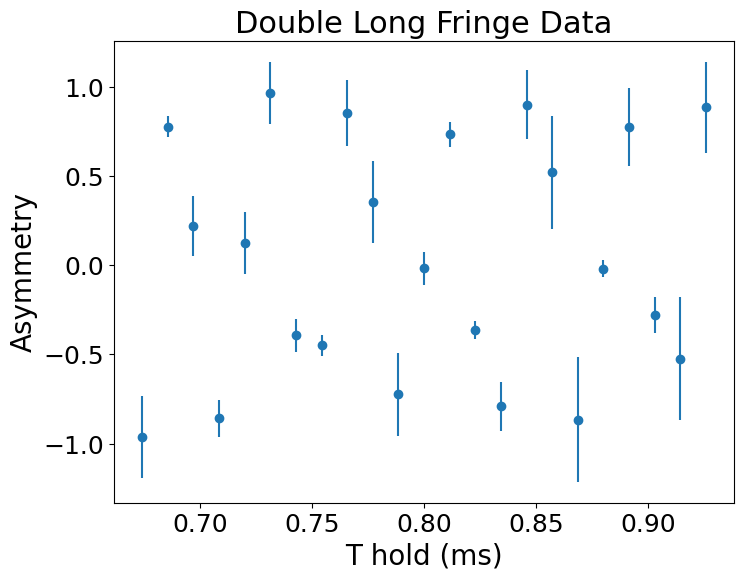

In [257]:
tlong, avglong, stdlong = gen_sample(little_g_fringe, center_t1_hold, f_samp1, want_no_samp*2+1)
plt.errorbar(tlong*1e3, avglong, yerr=stdlong, fmt='o', label='Sampled Data')
plt.title('Double Long Fringe Data')
plt.xlabel('T hold (ms)')   
plt.ylabel('Asymmetry')

Fit 1 Results:
  Offset: 0.024 ± 0.020
  Amplitude: 0.821 ± 0.031
  Freq: 24.800 ± 0.077 (kHz)
  Phase: 2.340 ± 0.128 (π rad)


Text(0.5, 0.98, 'Long Fringe Fitting\nTrue Freq: 25.0000  Freq Fit: 24.7999 +/- 0.077 kHz')

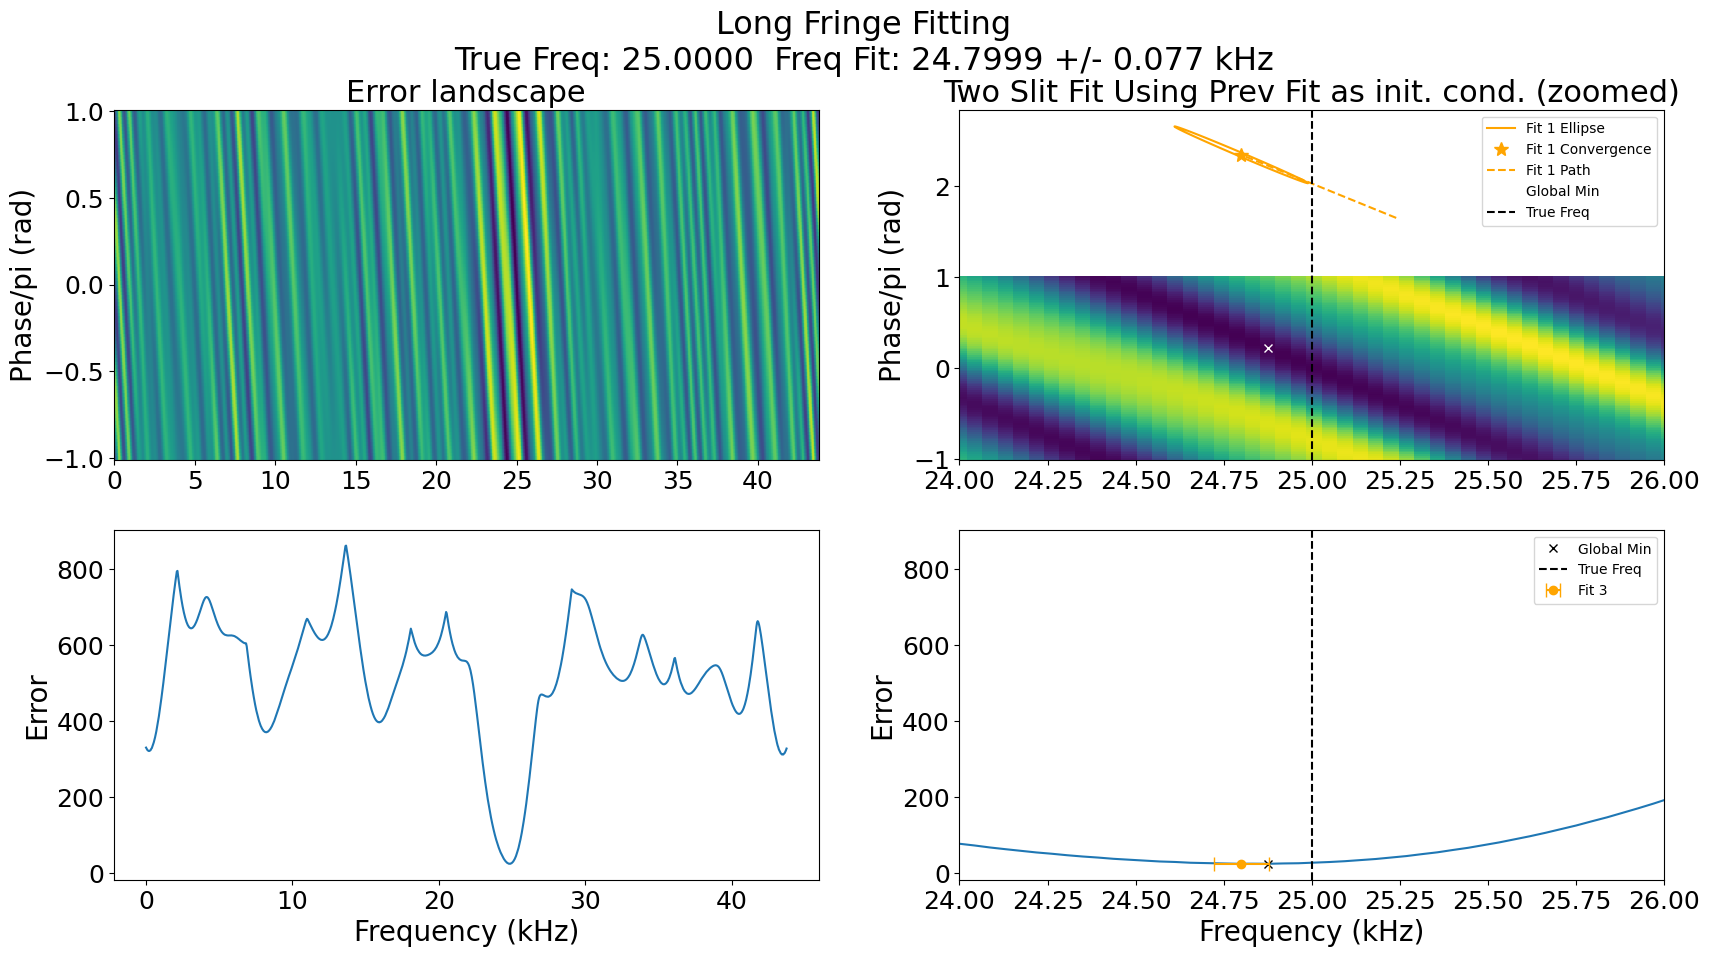

In [258]:
errors_long_2d = square_sin_error_weighted(tlong, avglong, stdlong, FREQ_RANGE, PHI_RANGE, want_2d=True)
long_mesh = np.meshgrid(PHI_RANGE, FREQ_RANGE)
errors_long_1d = square_sin_error_weighted(tlong, avglong, stdlong, FREQ_RANGE, PHI_RANGE, want_2d=False)
globmin_flong, globmin_philong = find_global_min(errors_long_2d, FREQ_RANGE, PHI_RANGE)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
globmin_f1, globmin_phi1 = find_global_min(errors_gate_2d, FREQ_RANGE, PHI_RANGE)

ax[0][0].pcolormesh(long_mesh[1]*1e-3, long_mesh[0]/(np.pi), errors_long_2d, shading='auto')
ax[0][0].set_title('Error landscape')
ax[0][0].set_ylabel('Phase/pi (rad)')

ax[1][0].plot(FREQ_RANGE*1e-3, errors_long_1d)
ax[1][0].set_xlabel('Frequency (kHz)')
ax[1][0].set_ylabel('Error')
# ax[1].set_xlim(24,26)

ax[0][1].pcolormesh(long_mesh[1]*1e-3, long_mesh[0]/(np.pi), errors_long_2d, shading='auto')
poptlong, pcovlong = fit_and_plot(tlong, avglong, stdlong, [0, 1, new_f_guess, new_phi_guess], 'orange', 1, ax=ax[0][1])

ax[0][1].plot(globmin_flong*1e-3, globmin_philong/np.pi, 'x', color='white', label='Global Min')
ax[0][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[0][1].set_title('Two Slit Fit Using Prev Fit as init. cond. (zoomed)')
ax[0][1].set_ylabel('Phase/pi (rad)')
ax[0][1].set_xlim(24,26)
ax[0][1].legend()

ax[1][1].plot(FREQ_RANGE*1e-3, errors_long_1d)
ax[1][1].plot(globmin_flong*1e-3, np.min(errors_long_1d), 'x', color='black', label='Global Min')
ax[1][1].errorbar(poptlong[2]*1e-3, errors_long_1d[np.argmin(np.abs(FREQ_RANGE - poptlong[2]))], xerr=np.sqrt(pcovlong[2,2])*1e-3, fmt='o', color='orange', label='Fit 3', capsize=5)
ax[1][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[1][1].set_xlabel('Frequency (kHz)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlim(24,26)
ax[1][1].legend()

fig.suptitle(f'Long Fringe Fitting\nTrue Freq: {f_1*1e-3:.4f}  Freq Fit: {poptlong[2]*1e-3:.4f} +/- {np.sqrt(pcovlong[2,2])*1e-3:.3f} kHz', fontsize=23)


### Triple Fringe vs Far Spaced Double Fringe

In [259]:
third_init_f = popt12a[2]
third_init_phi = popt12a[3]
FINE_FREQ_RANGE = np.linspace(24e3, 26e3, 1000)


Text(0.5, 1.0, 'Three Fringes')

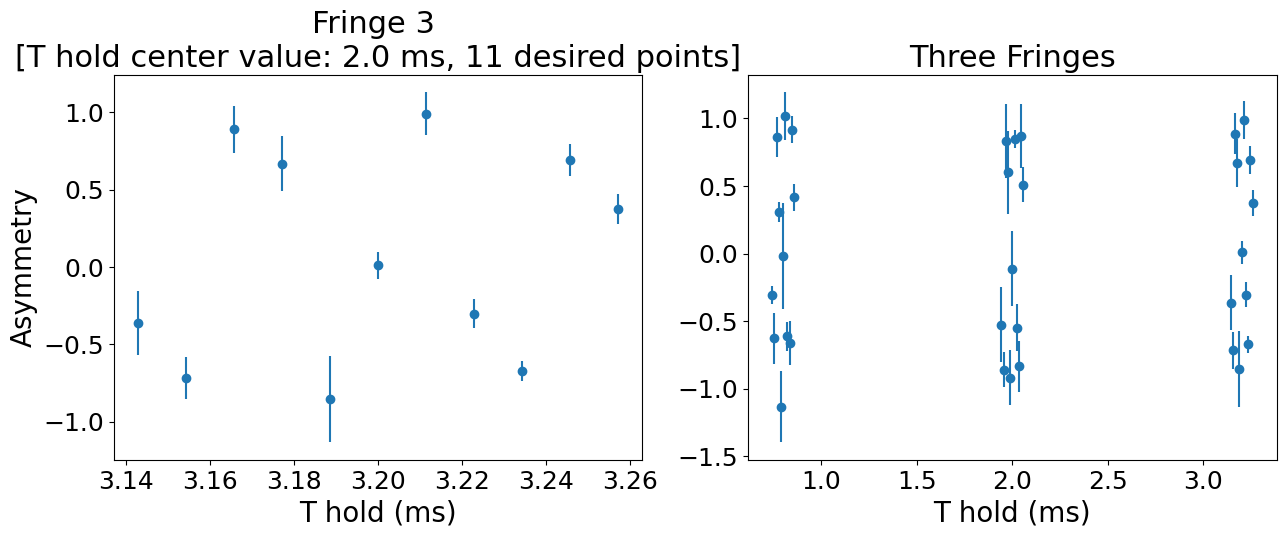

In [260]:
t3_center = t2_center + 30 * tau_1
t03s, avg03s, std03s = gen_sample(little_g_fringe, t3_center, f_samp1, want_no_samp)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].errorbar(t03s*1e3, avg03s, yerr=std03s, fmt='o', label='Sampled Data')
ax[0].set_xlabel('T hold (ms)')
ax[0].set_ylabel('Asymmetry')
ax[0].set_title(f'Fringe 3 \n[T hold center value: {t2_center*1e3:.1f} ms, {want_no_samp} desired points]')

t123s, avg123s, std123s = np.concatenate((t12s, t03s)), np.concatenate((avg12s, avg03s)), np.concatenate((std12s, std03s))
ax[1].errorbar(t123s*1e3, avg123s, yerr=std123s, fmt='o', label='Sampled Data')
ax[1].set_xlabel('T hold (ms)')
ax[1].set_title('Three Fringes')

Fit Old Results:
  Offset: 0.011 ± 0.031
  Amplitude: 0.952 ± 0.041
  Freq: 24.993 ± 0.012 (kHz)
  Phase: 2.030 ± 0.030 (π rad)
Fit 1 Results:
  Offset: 0.031 ± 0.020
  Amplitude: 0.934 ± 0.027
  Freq: 24.994 ± 0.004 (kHz)
  Phase: 2.033 ± 0.018 (π rad)


Text(0.5, 0.98, 'Triple Slit Fitting\nTrue Freq: 25.0000  Freq Fit: 24.9939 +/- 0.0039 kHz')

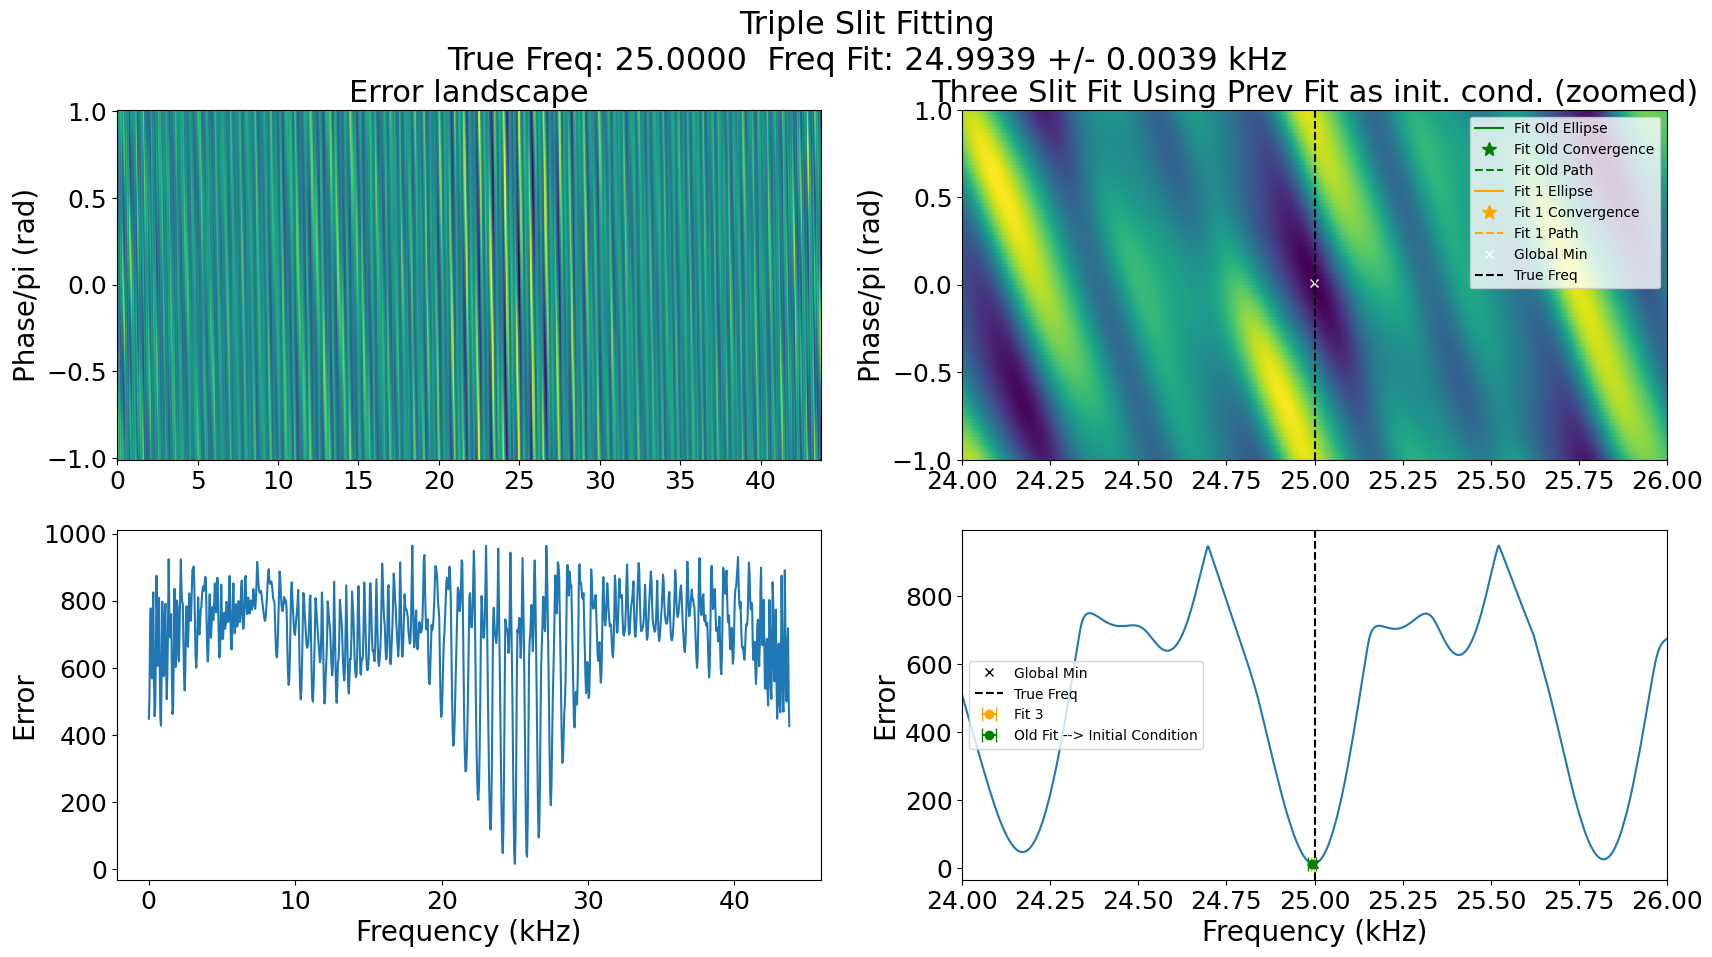

In [264]:
errors_gate123_2d = square_sin_error_weighted(t123s, avg123s, std123s, FREQ_RANGE, PHI_RANGE, want_2d=True)
gate_mesh123 = np.meshgrid(PHI_RANGE, FREQ_RANGE)
errors_gate123_1d = square_sin_error_weighted(t123s, avg123s, std123s, FREQ_RANGE, PHI_RANGE, want_2d=False)

fine_errors_gate123_2d = square_sin_error_weighted(t123s, avg123s, std123s, FINE_FREQ_RANGE, PHI_RANGE, want_2d=True)
fine_gate_mesh123 = np.meshgrid(PHI_RANGE, FINE_FREQ_RANGE)
fine_errors_gate123_1d = square_sin_error_weighted(t123s, avg123s, std123s, FINE_FREQ_RANGE, PHI_RANGE, want_2d=False)
fine_globmin_f123, fine_globmin_phi123 = find_global_min(fine_errors_gate123_2d, FINE_FREQ_RANGE, PHI_RANGE)    


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
# globmin_f1, globmin_phi1 = find_global_min(errors_gate_2d, FREQ_RANGE, PHI_RANGE)

ax[0][0].pcolormesh(gate_mesh123[1]*1e-3, gate_mesh123[0]/(np.pi), errors_gate123_2d, shading='auto')
ax[0][0].set_title('Error landscape')
ax[0][0].set_ylabel('Phase/pi (rad)')

ax[1][0].plot(FREQ_RANGE*1e-3, errors_gate123_1d)
ax[1][0].set_xlabel('Frequency (kHz)')
ax[1][0].set_ylabel('Error')
# ax[1].set_xlim(24,26)

ax[0][1].pcolormesh(fine_gate_mesh123[1]*1e-3, fine_gate_mesh123[0]/(np.pi), fine_errors_gate123_2d, shading='auto')

# Old Fit Ellipse
popt_old, pcov_old = fit_and_plot(t12s, avg12s, std12s, [0,1,new_f_guess,new_phi_guess], 'green', 'Old', ax=ax[0][1])

# New fit
popt123, pcov123 = fit_and_plot(t123s, avg123s, std123s, [0, 1, third_init_f, third_init_phi], 'orange', 1, ax=ax[0][1])

ax[0][1].plot(fine_globmin_f123*1e-3, fine_globmin_phi123/np.pi, 'x', color='white', label='Global Min')
ax[0][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[0][1].set_title('Three Slit Fit Using Prev Fit as init. cond. (zoomed)')
ax[0][1].set_ylabel('Phase/pi (rad)')
ax[0][1].set_xlim(24,26)
ax[0][1].set_ylim(-1,1)
ax[0][1].legend()

ax[1][1].plot(FINE_FREQ_RANGE*1e-3, fine_errors_gate123_1d)
ax[1][1].plot(fine_globmin_f123*1e-3, np.min(fine_errors_gate123_1d), 'x', color='black', label='Global Min')
ax[1][1].errorbar(popt123[2]*1e-3, fine_errors_gate123_1d[np.argmin(np.abs(FINE_FREQ_RANGE - popt123[2]))], xerr=np.sqrt(pcov123[2,2])*1e-3, fmt='o', color='orange', label='Fit 3', capsize=5)
ax[1][1].errorbar(popt12a[2]*1e-3, fine_errors_gate123_1d[np.argmin(np.abs(FINE_FREQ_RANGE - popt12a[2]))], xerr=np.sqrt(pcov12a[2,2])*1e-3, fmt='o', color='green', label='Old Fit --> Initial Condition', capsize=5)

ax[1][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[1][1].set_xlabel('Frequency (kHz)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlim(24,26)
ax[1][1].legend()

fig.suptitle(f'Triple Slit Fitting\nTrue Freq: {f_1*1e-3:.4f}  Freq Fit: {popt123[2]*1e-3:.4f} +/- {np.sqrt(pcov123[2,2])*1e-3:.4f} kHz', fontsize=23)


Text(0.5, 1.0, 'Two Far Spaced Fringes')

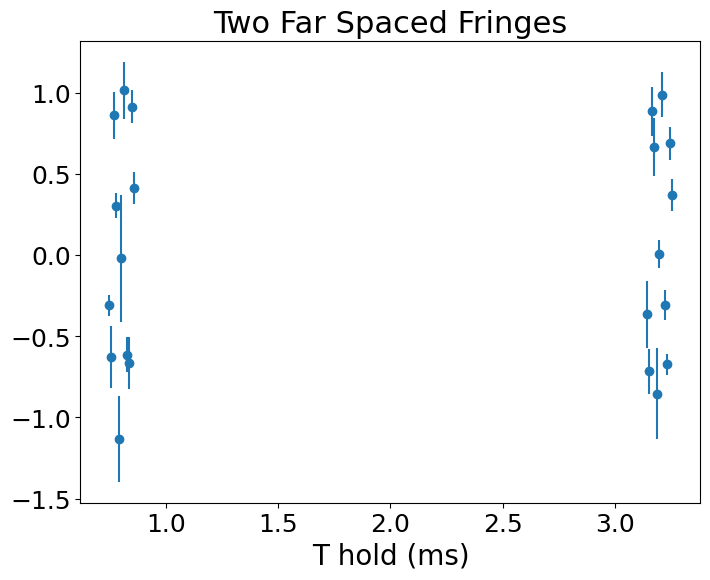

In [265]:
t13s, avg13s, std13s = np.concatenate((t01s, t03s)), np.concatenate((avg01s, avg03s)), np.concatenate((std01s, std03s))
plt.errorbar(t13s*1e3, avg13s, yerr=std13s, fmt='o', label='Sampled Data')
plt.xlabel('T hold (ms)')
plt.title('Two Far Spaced Fringes')

Fit Old Results:
  Offset: 0.011 ± 0.031
  Amplitude: 0.952 ± 0.041
  Freq: 24.993 ± 0.012 (kHz)
  Phase: 2.030 ± 0.030 (π rad)
Fit 1 Results:
  Offset: 0.057 ± 0.023
  Amplitude: 0.934 ± 0.034
  Freq: 24.992 ± 0.004 (kHz)
  Phase: 2.043 ± 0.019 (π rad)


Text(0.5, 0.98, 'Two Slit Spaced Fitting\nTrue Freq: 25.0000  Freq Fit: 24.9921 +/- 0.0041 kHz')

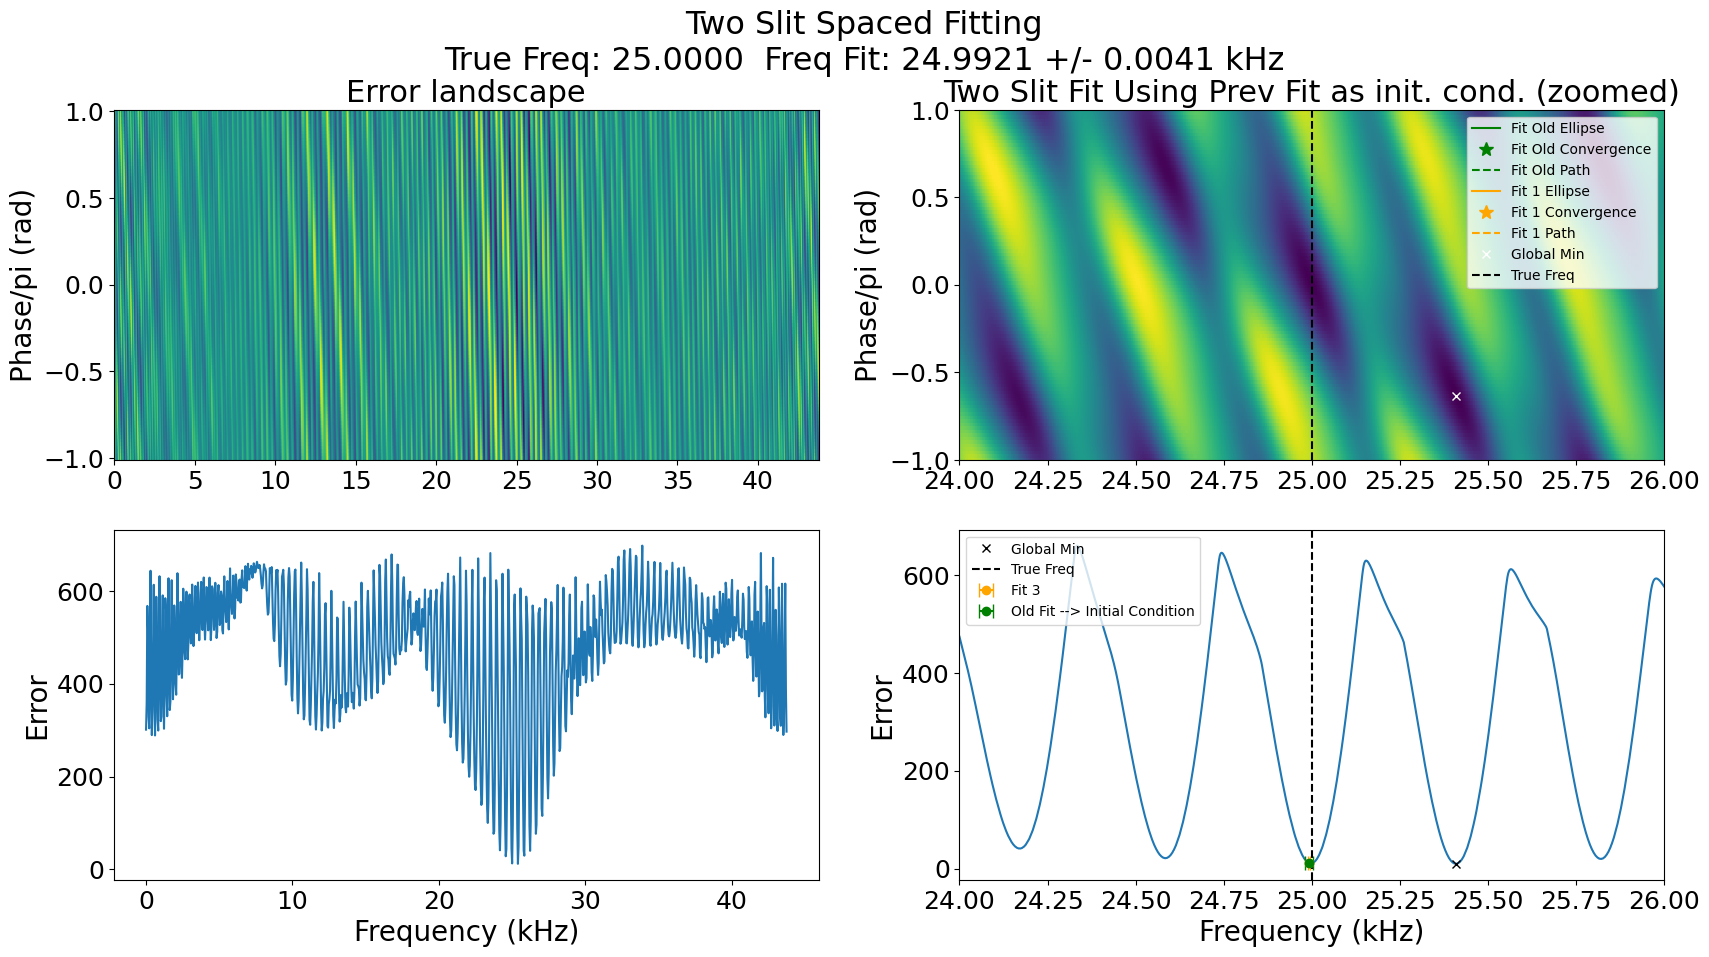

In [266]:
errors_gate13_2d = square_sin_error_weighted(t13s, avg13s, std13s, FREQ_RANGE, PHI_RANGE, want_2d=True)
gate_mesh13 = np.meshgrid(PHI_RANGE, FREQ_RANGE)
errors_gate13_1d = square_sin_error_weighted(t13s, avg13s, std13s, FREQ_RANGE, PHI_RANGE, want_2d=False)

# Fine spacing
fine_errors_gate13_2d = square_sin_error_weighted(t13s, avg13s, std13s, FINE_FREQ_RANGE, PHI_RANGE, want_2d=True)
fine_gate_mesh13 = np.meshgrid(PHI_RANGE, FINE_FREQ_RANGE)
fine_errors_gate13_1d = square_sin_error_weighted(t13s, avg13s, std13s, FINE_FREQ_RANGE, PHI_RANGE, want_2d=False)
fine_globmin_f13, fine_globmin_phi13 = find_global_min(fine_errors_gate13_2d, FINE_FREQ_RANGE, PHI_RANGE)


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
# globmin_f1, globmin_phi1 = find_global_min(errors_gate_2d, FREQ_RANGE, PHI_RANGE)

ax[0][0].pcolormesh(gate_mesh13[1]*1e-3, gate_mesh13[0]/(np.pi), errors_gate13_2d, shading='auto')
ax[0][0].set_title('Error landscape')
ax[0][0].set_ylabel('Phase/pi (rad)')

ax[1][0].plot(FREQ_RANGE*1e-3, errors_gate13_1d)
ax[1][0].set_xlabel('Frequency (kHz)')
ax[1][0].set_ylabel('Error')
# ax[1].set_xlim(24,26)

ax[0][1].pcolormesh(fine_gate_mesh13[1]*1e-3, fine_gate_mesh13[0]/(np.pi), fine_errors_gate13_2d, shading='auto')

# Old Fit Ellipse
popt_old, pcov_old = fit_and_plot(t12s, avg12s, std12s, [0,1,new_f_guess,new_phi_guess], 'green', 'Old', ax=ax[0][1])

# New fit
popt13, pcov13 = fit_and_plot(t13s, avg13s, std13s, [0, 1, third_init_f, third_init_phi], 'orange', 1, ax=ax[0][1])

ax[0][1].plot(fine_globmin_f13*1e-3, fine_globmin_phi13/np.pi, 'x', color='white', label='Global Min')
ax[0][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[0][1].set_title('Two Slit Fit Using Prev Fit as init. cond. (zoomed)')
ax[0][1].set_ylabel('Phase/pi (rad)')
ax[0][1].set_xlim(24,26)
ax[0][1].set_ylim(-1,1)
ax[0][1].legend()

ax[1][1].plot(FINE_FREQ_RANGE*1e-3, fine_errors_gate13_1d)
ax[1][1].plot(fine_globmin_f13*1e-3, np.min(fine_errors_gate13_1d), 'x', color='black', label='Global Min')
ax[1][1].errorbar(popt13[2]*1e-3, fine_errors_gate13_1d[np.argmin(np.abs(FINE_FREQ_RANGE - popt13[2]))], xerr=np.sqrt(pcov13[2,2])*1e-3, fmt='o', color='orange', label='Fit 3', capsize=5)
ax[1][1].errorbar(popt12a[2]*1e-3, fine_errors_gate13_1d[np.argmin(np.abs(FINE_FREQ_RANGE - popt12a[2]))], xerr=np.sqrt(pcov12a[2,2])*1e-3, fmt='o', color='green', label='Old Fit --> Initial Condition', capsize=5)

ax[1][1].axvline(f_1*1e-3, color='black', linestyle='--', label='True Freq')
ax[1][1].set_xlabel('Frequency (kHz)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlim(24,26)
ax[1][1].legend()

fig.suptitle(f'Two Slit Spaced Fitting\nTrue Freq: {f_1*1e-3:.4f}  Freq Fit: {popt13[2]*1e-3:.4f} +/- {np.sqrt(pcov13[2,2])*1e-3:.4f} kHz', fontsize=23)
